In [15]:
import random
import threading
import time
from ipywidgets import IntProgress
from IPython.display import display
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value, LpStatus  
import matplotlib.pyplot as plt

In [16]:
class Generation_data:
    def __init__(self, nb_objets, nbres_camions):
        self.nb_objets = nb_objets
        self.nbres_camions = nbres_camions
        self.grand_tableau = self.generer_tableau()
        self.tableau_camion = self.gen_tab_camion()

    def generer_tableau(self):
        nb_villes = self.nb_objets * 2
        tab_ville = list(range(1, nb_villes + 1))
        grand_tableau = []

        for _ in range(nb_villes // 2):
            ville_collecte = tab_ville.pop(random.randint(0, len(tab_ville) - 1))
            ville_livraison = tab_ville.pop(random.randint(0, len(tab_ville) - 1))
            camion = random.randint(1, self.nbres_camions)
            grand_tableau.append([ville_collecte, ville_livraison, [camion]])

        return grand_tableau

    def gen_tab_camion(self):
        tab_camion = [[] for _ in range(self.nbres_camions)]

        for route in self.grand_tableau:
            camion_index = route[2][0] - 1
            tab_camion[camion_index].extend([route[0], route[1]])

        return tab_camion

    def affichage_camions(self):
        for i, camions in enumerate(self.tableau_camion):
            print(f"Camion {i + 1} : {camions}")


    def affichage_1_camion(self, id):
        return self.tableau_camion[id - 1]


In [17]:
# fonction de traitement 
def fonction_traitement(sommets):
    return max(sommets)

def afficher_itineraire(itineraire, temps_trajet):
    trajets = []
    durees = []
    for i in range(len(itineraire) - 1):
        trajets.append(f"{itineraire[i]} -> {itineraire[i + 1]}")
        durees.append(f"{temps_trajet[itineraire[i] - 1][itineraire[i + 1] - 1]} min")
    trajets.append(f"{itineraire[-1]} -> {itineraire[0]}")
    durees.append(f"{temps_trajet[itineraire[-1] - 1][itineraire[0] - 1]} min")

    formatted_trajets = " , ".join(trajets) + " / "
    return formatted_trajets + " -> ".join(durees)


In [18]:
def meilleur_trajet_camion(villes_camion):
    meilleurs_itineraires_camion = []
    meilleurs_temps_camion = []
    
    bar1 = IntProgress(min=0, max=nb_trajets_depart, layout={"width" : "100%"})
    display(bar1)
    
    for i in range (nb_trajets_depart):
        itineraire_initial = random_trajet_depart(villes_camion)
        meilleur_itineraire, meilleur_temps = hill_climbing_tabou(temps_trajet_routes, itineraire_initial, taille_tabou)
        
        meilleurs_itineraires_camion.append(meilleur_itineraire)
        meilleurs_temps_camion.append(meilleur_temps)
        
        bar1.value += 1
        
    index_meilleur_temps = meilleurs_temps_camion.index(min(meilleurs_temps_camion))
    meilleur_itineraire = meilleurs_itineraires_camion[index_meilleur_temps]
    meilleur_temps = meilleurs_temps_camion[index_meilleur_temps]
    bar1.close()
    return meilleur_itineraire, meilleur_temps

def random_trajet_depart(villes_camion):
    # Construire une liste de couples (collecte, livraison)
    objets = [(villes_camion[i], villes_camion[i + 1]) for i in range(0, len(villes_camion), 2)]
    
    # Séparer les points de collecte et de livraison
    collectes = [collecte for collecte, _ in objets]
    livraisons = {livraison: collecte for collecte, livraison in objets}
    random.seed(a=3)

    # Mélanger aléatoirement les points de collecte
    random.shuffle(collectes)
    
    # Initialiser la liste d'itinéraire avec les collectes
    trajet = collectes[:]
    
    # Insérer chaque point de livraison à un index aléatoire après son point de collecte associé
    for livraison, collecte in livraisons.items():
        index_collecte = trajet.index(collecte)
        index_livraison = random.randint(index_collecte + 1, len(trajet))
        trajet.insert(index_livraison, livraison)
    
    return trajet

def hill_climbing_tabou(temps_trajet, itineraire_initial, taille_tabou):
    itineraire = itineraire_initial[:]
    meilleur_itineraire = itineraire[:]
    meilleur_cout = calculer_cout(meilleur_itineraire, temps_trajet)
    liste_tabou = []
    iter_count = 0

    while True:
        if meilleur_itineraire == None:
            meilleur_itineraire = min(liste_tabou, key=lambda x: calculer_cout(list(x), temps_trajet))
            meilleur_cout = calculer_cout(list(meilleur_itineraire), temps_trajet) 
            return meilleur_itineraire, meilleur_cout
      
        voisins = voisinage(itineraire_initial, meilleur_itineraire)
        meilleur_voisin = None
        meilleur_voisin_cout = float('inf')

        #On parcourt tous les voisins
        for voisin in voisins:
            if voisin in liste_tabou or voisin == None:
                continue
            
            cout_voisin = calculer_cout(voisin, temps_trajet)
            
            if meilleur_voisin == None :
                meilleur_voisin = voisin
                meilleur_voisin_cout = cout_voisin
                
            elif cout_voisin < meilleur_voisin_cout:
                meilleur_voisin = voisin
                meilleur_voisin_cout = cout_voisin
                
            if cout_voisin < meilleur_cout:
                meilleur_itineraire = voisin
                meilleur_cout = cout_voisin
                break
                
        if len(liste_tabou) < taille_tabou:
            meilleur_itineraire = meilleur_voisin
            meilleur_cout = meilleur_voisin_cout
            if meilleur_itineraire == None:
                continue
            liste_tabou.append(meilleur_itineraire)
                
        else:
            meilleur_itineraire = min(liste_tabou, key=lambda x: calculer_cout(list(x), temps_trajet))
            meilleur_cout = calculer_cout(list(meilleur_itineraire), temps_trajet) 
            return meilleur_itineraire, meilleur_cout
    iter_count += 1

def calculer_cout(itineraire, temps_trajet):
    cout = 0
    for i in range(len(itineraire) - 1):
        cout += temps_trajet[itineraire[i] - 1][itineraire[i + 1] - 1]
    cout += temps_trajet[itineraire[-1] - 1][itineraire[0] - 1]  # Retour au point de départ
    return cout

def voisinage(itineraire_c_et_l, itineraire):
    voisins = []
    nb_villes = len(itineraire)

    for i in range(1, nb_villes):  # Commence à 1 pour laisser le point de départ fixe
        for j in range(i + 1, nb_villes):
            # Créer un voisin en permutant les points i et j
            voisin = itineraire[:]
            voisin[i], voisin[j] = voisin[j], voisin[i]
            
            # Vérifier que le voisin respecte les contraintes de collecte et de livraison
            valide = True
            for k in range(0, len(itineraire_c_et_l), 2):
                collecte = itineraire_c_et_l[k]
                livraison = itineraire_c_et_l[k + 1]
                
                # Trouver les indices de la collecte et de la livraison dans le voisin
                indice_collecte = voisin.index(collecte)
                indice_livraison = voisin.index(livraison)
                
                # Si la livraison est avant la collecte, c'est invalide
                if indice_livraison < indice_collecte:
                    valide = False
                    break
            
            # Si le voisin est valide, l'ajouter à la liste des voisins
            if valide:
                voisins.append(voisin)
                
    return voisins


In [19]:
def random_temps_trajet(temps_min, temps_max, nb_villes):
    temps_trajet = []
    for i in range(nb_villes):
        ligne = []
        for j in range(nb_villes):
            if i == j:
                ligne.append(0)
            elif i < j:
                temps = random.randint(temps_min, temps_max)
                ligne.append(temps)
            else:
                ligne.append(temps_trajet[j][i])
        temps_trajet.append(ligne)
    return temps_trajet 

def solveur_simplex_camion(sommets, temps_trajet_routes):
    nb_villes = len(sommets)
    
    # Create the linear programming problem
    prob = LpProblem("TSP_Single_Truck", LpMinimize)
    
    # Decision variables: x[i,j] is 1 if the route from i to j is taken, otherwise 0
    x = LpVariable.dicts("x", (range(nb_villes), range(nb_villes)), cat='Binary')
    
    # Objective function: minimize the total travel time
    prob += lpSum(temps_trajet_routes[i][j] * x[i][j] for i in range(nb_villes) for j in range(nb_villes) if i != j)
    
    # Constraints: each city must be visited once for collection and once for delivery
    for i in range(nb_villes):
        prob += lpSum(x[i][j] for j in range(nb_villes) if i != j) == 1
        prob += lpSum(x[j][i] for j in range(nb_villes) if i != j) == 1
    
    # Solve the problem
    prob.solve()
    
    # Check for optimality and return the lower bound value
    if LpStatus[prob.status] == 'Optimal':
        return value(prob.objective)
    else:
        return None

def extract_submatrix(matrix, indices):
    submatrix = []
    for i in indices:
        row = []
        for j in indices:
            row.append(matrix[i-1][j-1])
        submatrix.append(row)
    return submatrix

In [20]:
def mono_thread(k):
    camion_list = logistics.affichage_1_camion(k)
    print("Camion ", k, " : ", camion_list)

    meilleur_itineraire, meilleur_temps = meilleur_trajet_camion(camion_list)
    
    with results_lock:
        r = [meilleur_itineraire, meilleur_temps]
        results.append(r)
    
def launch_threads(k):
    threads = []
    start_time = time.time()  # Start 
    
    for i in range(k):
        thread = threading.Thread(target=mono_thread, args=(i + 1,))
        threads.append(thread)
        thread.start()
        
    for thread in threads:
        thread.join()
    
    end_time = time.time()  # Stop
    
    total_duration = end_time - start_time
    print(f"Temps d'exécution : {total_duration:.4f} secondes")
    print("All threads finished")
    index_max_time = max(range(len(results)), key=lambda i: results[i][1])

    #Simplexe du pire camion
    camion_list = logistics.affichage_1_camion(index_max_time)
    temps_trajets_camions = extract_submatrix(temps_trajet_routes, camion_list)
    
    borne_inf = solveur_simplex_camion(camion_list, temps_trajets_camions)
    
    itineraire_pire_camion = results[index_max_time][0]
    temps_pire_camion = results[index_max_time][1]
    rapprochement_borne = (borne_inf / temps_pire_camion) * 100
    results.clear()  # Réinitialiser results après utilisation
    return rapprochement_borne, total_duration

Camion  1  :  [2, 4, 5, 3, 1, 7, 8, 6, 10, 9]


IntProgress(value=0, layout=Layout(width='100%'))

Temps d'exécution : 0.4161 secondes
All threads finished
Camion  1  :  [9, 18, 20, 12, 16, 11, 1, 8, 2, 19, 14, 10, 7, 15, 3, 17, 4, 6, 13, 5]


IntProgress(value=0, layout=Layout(width='100%'))

Temps d'exécution : 2.7653 secondes
All threads finished
Camion  1  :  [1, 29, 26, 6, 5, 3, 20, 4, 23, 24, 16, 11, 8, 21, 25, 18, 13, 12, 15, 19, 9, 30, 27, 28, 17, 7, 14, 10, 2, 22]


IntProgress(value=0, layout=Layout(width='100%'))

Temps d'exécution : 9.4964 secondes
All threads finished
Camion  1  :  [5, 31, 29, 25, 38, 30, 26, 7, 19, 15, 6, 18, 35, 16]
Camion  2  :  [21, 8, 33, 39, 9, 28, 36, 13, 4, 34, 32, 22, 2, 40, 10, 12, 14, 37, 23, 27, 20, 24, 1, 11, 17, 3]


IntProgress(value=0, layout=Layout(width='100%'))

IntProgress(value=0, layout=Layout(width='100%'))

Temps d'exécution : 7.1094 secondes
All threads finished
Taille des instances: [5, 10, 15, 20]
Rapprochements: [89.04847396768402, 90.11857707509881, 88.0, 52.98218435321457]
Temps d'exécution: [0.4160923957824707, 2.765319585800171, 9.496379613876343, 7.1094443798065186]


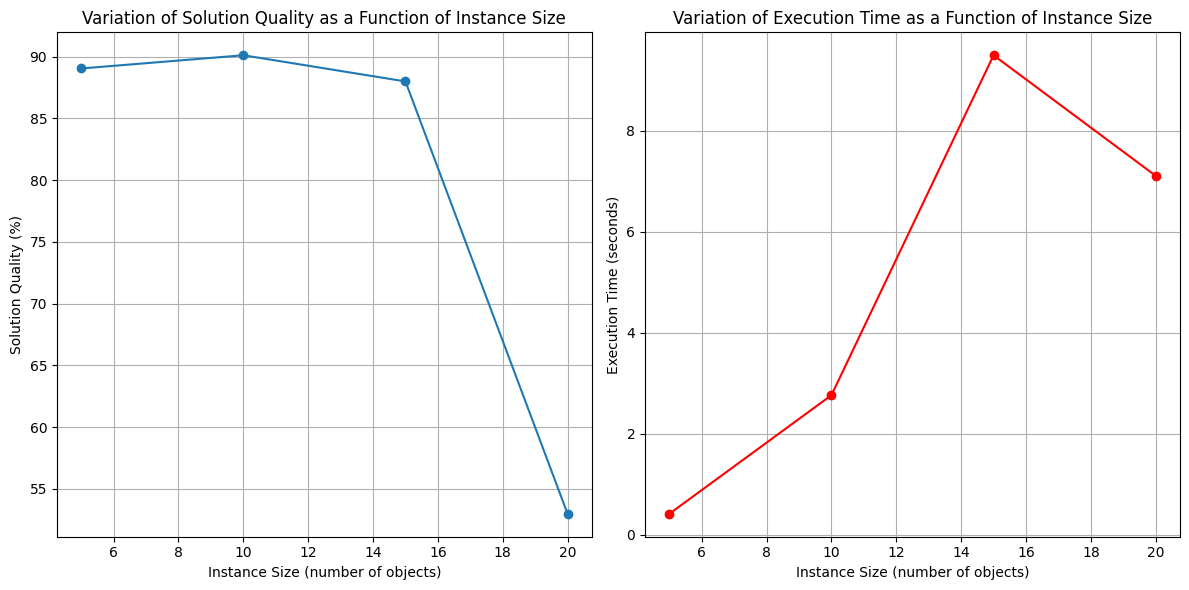

In [21]:
results_lock = threading.Lock()
random.seed(a=5)
nb_trajets_depart = 100
taille_tabou = 50
#nombres_objets = 10
instance_sizes = [5, 10, 15, 20]#, 25, 30, 35, 45, 200, 500]  # Taille d'instances (nombre d'objet)
#nombres_camions = 2
rapprochements = []
execution_times = []
for size in instance_sizes:
    nombres_objets = size
    nombres_camions = max(1, nombres_objets // 10)
    nombres_villes = nombres_objets * 2
    temps_trajet_routes = random_temps_trajet(40, 100, nombres_villes)
    logistics = Generation_data(nombres_objets, nombres_camions)
    results = []  
    rapprochement, exec_time = launch_threads(nombres_camions)
    rapprochements.append(rapprochement)
    execution_times.append(exec_time)

print("Taille des instances:", instance_sizes)
print("Rapprochements:", rapprochements)
print("Temps d'exécution:", execution_times)

# Generation of the first graph for quality
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(instance_sizes, rapprochements, marker='o')
plt.xlabel('Instance Size (number of objects)')
plt.ylabel('Solution Quality (%)')
plt.title('Variation of Solution Quality as a Function of Instance Size')
plt.grid(True)

# Generation of the second graph for execution times
plt.subplot(1, 2, 2)
plt.plot(instance_sizes, execution_times, marker='o', color='r')
plt.xlabel('Instance Size (number of objects)')
plt.ylabel('Execution Time (seconds)')
plt.title('Variation of Execution Time as a Function of Instance Size')
plt.grid(True)

plt.tight_layout()
plt.show()